In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Input, Softmax, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical
import os
import cv2
import keras
from sklearn.cluster import KMeans

Using TensorFlow backend.


In [5]:
class ExtractBloodCellType():
    def __init__(self,f_name):
        self.img = cv2.imread(f_name)
        self.model = Sequential()
        self.cell_type = {0:"EOSINOPHIL",1:"LYMPHOCYTE",2:"MONOCYTE",3:"NEUTROPHIL"}
        
    def print_img(self,img):
        cv2.imshow("Cells",img)
        cv2.waitKey(0)
        cv2.destroyWindow()
    
    def genrate_filter(self):
        clust = self.img.reshape((-1,3))
        clust = np.float32(clust)
        criteria  = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        ret,label,center  = cv2.kmeans(clust,3,None,criteria,10,cv2.KMEANS_PP_CENTERS)

        center = np.uint8(center)
        res = center[label.flatten()]
        res2 = res.reshape((self.img.shape))
        channels = cv2.split(res2)
        
        data = np.unique(channels[0])
        base_img = np.zeros((self.img.shape),dtype=np.uint8)
        for i in range(base_img.shape[0]):
            for j in range(base_img.shape[1]):
                if(channels[0][i][j]==data[2]):
                    base_img[i][j]=255
                else:
                    base_img[i][j]=0

        img_blur = cv2.medianBlur(base_img,5).astype('uint8')
        kernel = np.ones((5, 5), np.uint8) 
        image = cv2.erode(img_blur, kernel,iterations=3)
        image = cv2.dilate(image, kernel,iterations=3)
        
        return img_blur
    
    def build_model(self):
        input_shape = (60, 80, 3)
        
        self.model.add(Conv2D(32, (11,11), padding="same",activation="relu",input_shape=input_shape))
        self.model.add(Conv2D(32, (7,7), padding="valid",activation="relu",input_shape=input_shape))
        self.model.add(MaxPool2D(pool_size=(2, 2)))
        
        self.model.add(Conv2D(32, (5, 5), padding="same",activation="relu"))
        self.model.add(Conv2D(32, (5, 5), padding="valid",activation="relu"))
        self.model.add(MaxPool2D(pool_size=(2, 2)))
        
        self.model.add(Conv2D(64, (3, 3), padding="same",activation="relu"))
        self.model.add(Conv2D(64, (3, 3), padding="valid",activation="relu"))
        self.model.add(MaxPool2D(pool_size=(2, 2)))
        self.model.add(BatchNormalization())
        self.model.add(Flatten())
        
        self.model.add(Dense(1024,activation="relu"))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(4,activation="softmax"))
        
        self.model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    def get_model(self):
        self.model = load_model("weights.hdf5")
    
    def predict_cell_type(self):
        pred_img = cv2.resize(self.img.copy(),(80,60))
        data = np.array([pred_img])
        predictions = self.model.predict_classes(data)
        print("Predicted cell type: "+ self.cell_type[predictions[0]])
    
    def segment_img(self):
        crop_img = self.img.copy()
        seg_img = self.genrate_filter()
        seg_img = cv2.cvtColor(seg_img,cv2.COLOR_BGR2GRAY)
        new_img = cv2.cvtColor(self.img,cv2.COLOR_BGR2GRAY)
        fg = cv2.bitwise_and(new_img,new_img,mask=seg_img)

        contours, hierarchy = cv2.findContours(fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if(len(contours)!=0):
            for c in contours:
                x,y,w,h = cv2.boundingRect(c)
                if(w*h>700):
                    cv2.putText(crop_img,"Detected",(x,y-20),cv2.FONT_HERSHEY_SIMPLEX ,1,(255,0,0), 2, cv2.LINE_AA) 
                    cv2.rectangle(crop_img,(x,y),(x+w,y+h),(255,0,0),2)
                    
        plt.imshow(crop_img)
    
    def count_cells(self):
        crop_img = self.img.copy()
        seg_img = self.genrate_filter()
        seg_img = cv2.cvtColor(seg_img,cv2.COLOR_BGR2GRAY)
        new_img = cv2.cvtColor(self.img,cv2.COLOR_BGR2GRAY)
        fg = cv2.bitwise_and(new_img,new_img,mask=seg_img)
        contours, hierarchy = cv2.findContours(fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if(len(contours)!=0):
            for c in contours:
                x,y,w,h = cv2.boundingRect(c)
                cv2.rectangle(crop_img,(x,y),(x+w,y+h),(255,0,0),2)
        print("WBC cells count: ",len(contours))
        plt.imshow(crop_img)
    
    def print_model_summary(self):
        self.model.summary()

# Here, we are detecing major white blood cell, which are important  for our immune system

Predicted cell type: NEUTROPHIL


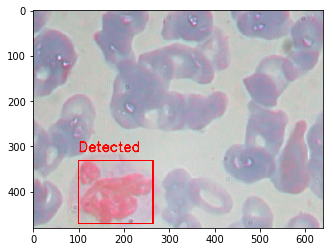

In [11]:
if __name__ == "__main__":
        ebct = ExtractBloodCellType("data/JPEGImages/BloodImage_00001.jpg")
        ebct.build_model()
        ebct.get_model()
        ebct.predict_cell_type()
        ebct.segment_img()

# Here, we are detecting count of white blood cell in our blood and this may help us to know health of our blood using this image processing.

WBC cells count:  9


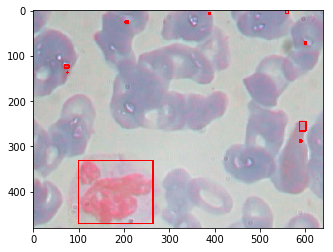

In [12]:
ebct.count_cells()

Predicted cell type: LYMPHOCYTE


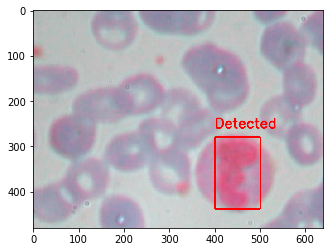

In [14]:
ebct = ExtractBloodCellType("data/JPEGImages/BloodImage_00200.jpg")
ebct.build_model()
ebct.get_model()
ebct.predict_cell_type()
ebct.segment_img()

WBC cells count:  4


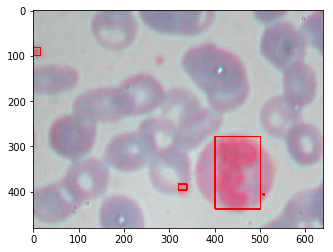

In [15]:
ebct.count_cells()

## from above results, we can easily see WBC count and can know about status of Immune system.

In [17]:
ebct.print_model_summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 80, 32)        11648     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 74, 32)        50208     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 37, 32)        25632     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 33, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 16, 64)       